# Data Pre-Processing

Here the data will be processed into a smaller dataset composed of polygons instead of points.  The polygons will be average elevation for the points inside

In [1]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import pylas
from shapely.geometry import Polygon, Point
import gc

epsg = 4289
lasPath = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/'
extent = (-90.14003111,  29.86560481, -89.87, 30.08)
sampleSquareSize = 100

In [2]:
xmlFilesGeo = gpd.GeoDataFrame(pd.read_pickle('./xmlFilesGeo.pickle'))
xmlFilesGeo = xmlFilesGeo[xmlFilesGeo['overLap']].copy()

In [3]:
neighborhoodDf = gpd.read_file('zip://./NewOrleansShapeFiles/Neighborhood_Statistical_Areas.zip!Neighborhood_Statistical_Areas.shp').to_crs(epsg=epsg)
waterDf = gpd.read_file('zip://./NewOrleansShapeFiles/water.zip!WATER2.SHP')

In [4]:
xmlFilesGeo.head()

,filename,overLap,eastOverLap,northOverLap,northbc,southbc,eastbc,westbc,ftpFileName,geometry
4,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp995270_L...,True,True,True,30.050959,30.037075,-89.878328,-89.894287,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...,"POLYGON ((-89.89429 30.05096, -89.87833 30.050..."
12,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp860255_L...,True,True,True,30.040672,30.026802,-90.018579,-90.034520,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...,"POLYGON ((-90.03452 30.04067, -90.01858 30.040..."
15,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp755240_L...,True,True,True,30.026428,30.015704,-90.127830,-90.143665,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...,"POLYGON ((-90.14366 30.02643, -90.12783 30.026..."
23,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp770165_L...,True,True,True,29.961624,29.947765,-90.114160,-90.130075,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...,"POLYGON ((-90.13008 29.96162, -90.11416 29.961..."
28,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp950330_L...,True,True,True,30.100587,30.092242,-89.923432,-89.930972,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...,"POLYGON ((-89.93097 30.10059, -89.92343 30.100..."


Extent: (-90.14003111, 29.86560481, -89.87, 30.08)


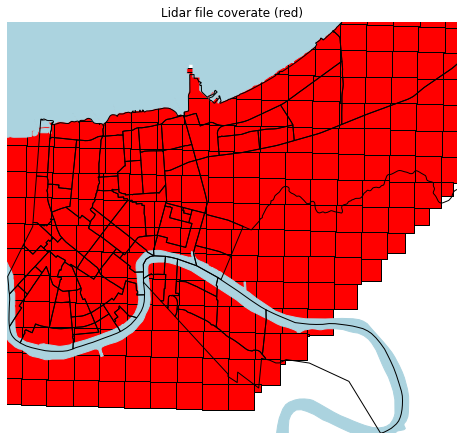

In [5]:
projection = gplt.Mercator()
fig, ax = plt.subplots(figsize=(16,6), subplot_kw={'projection': projection})

extent = (-90.14003111,  29.86560481, -89.87, 30.08)

gplt.polyplot(xmlFilesGeo,ax=ax, projection=projection, edgecolor='#000000', facecolor='#ff0000', extent=extent, zorder=21)
gplt.polyplot(waterDf,ax=ax, projection=projection, edgecolor='#abd3df', facecolor='#abd3df', extent=extent, zorder=22)
gplt.polyplot(neighborhoodDf, edgecolor='black', facecolor=(1,0,0,0), projection=projection, ax=ax, extent=extent, zorder=23)

fig.tight_layout()
ax.set_title('Lidar file coverate (red)')

print("Extent:", extent)

In [6]:
class LoadFileException(Exception):
    pass

def loadFile(fileName):
    
    with zipfile.ZipFile(lasPath + fileName[0]) as f:
        rawData = f.read(fileName[1])
        lasData = pylas.read(rawData)
    
    del rawData
    
    ground = lasData.classification == 2
    pointCount = np.count_nonzero(ground)
   
    if  pointCount == 0:
        raise(LoadFileException('No ground/lowveg points in this dataset'))
    
    X = lasData.x[ground]
    Y = lasData.y[ground]
    Z = lasData.z[ground]
    
    df = gpd.GeoDataFrame(Z, geometry=gpd.points_from_xy(X,Y), columns=['elevation']).set_crs(32215)
    
    return df

In [7]:
%%time
fullFileName = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/USGS_LPC_LA_UpperDeltaPlain_2017_15ryp755120_LAS_2018.zip'
fileName = fullFileName.split('/')[-1]
lasDf = loadFile((fileName, fileName.replace('.zip','.las')))
lasDf.head()

CPU times: user 23.8 s, sys: 451 ms, total: 24.2 s
Wall time: 24.3 s


<AxesSubplot:>

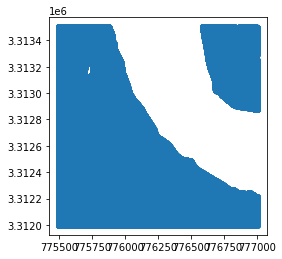

In [8]:
lasDf.plot()

In [9]:
%%time
bounds = lasDf.total_bounds

CPU times: user 32.7 s, sys: 136 ms, total: 32.8 s
Wall time: 32.8 s


In [10]:
#gplt.choroplethe sampling polygons

def makeSamplePolygons(bounds):
    polygons = []
    for x in range(int(bounds[0]), int(bounds[2]), sampleSquareSize):
        for y in range(int(bounds[1]), int(bounds[3]), sampleSquareSize):
            polygons.append(Polygon([
                (x,y),
                (x+sampleSquareSize,y),
                (x+sampleSquareSize, y+sampleSquareSize),
                (x,y+sampleSquareSize)
                ]))
            
    return gpd.GeoDataFrame(geometry=polygons).set_crs(32215)


In [11]:
samplePolyDf = makeSamplePolygons(bounds)

In [12]:
samplePolyDf.total_bounds

array([ 775500., 3312000.,  777000., 3313500.])

In [13]:
bounds

array([ 775500.  , 3312000.  ,  776999.99, 3313499.99])

<AxesSubplot:>

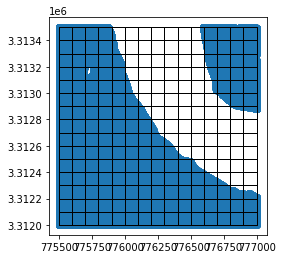

In [14]:
fig, ax = plt.subplots(1)
samplePolyDf.plot(facecolor=(1,0,0,0), edgecolor='black', ax=ax, zorder=5)
lasDf.plot(ax=ax)

In [15]:
#same as other LoadFile function but returns raw data
class LoadFileException(Exception):
    pass

def loadLas(fileName):
    
    with zipfile.ZipFile(lasPath + fileName[0]) as f:
        rawData = f.read(fileName[1])
        lasData = pylas.read(rawData)
    
    del rawData
    
    pointType = 2
    ground = lasData.classification == 2
    
    #probably water
    if np.count_nonzero(ground)==0:
        ground = lasData.classification == 9
        pointType = 9
    
    #if no points use low vegitation
    if np.count_nonzero(ground)==0:
        ground = lasData.classification == 3
        pointType = 3
    
    #medium veg
    if np.count_nonzero(ground)==0:
        ground = lasData.classification == 4
        pointType = 4
        
    #high veg
    if np.count_nonzero(ground)==0:
        ground = lasData.classification == 5
        pointType = 5
    
    #unclassified
    if np.count_nonzero(ground)==0:
        ground = lasData.classification == 1
        pointType = 1
        
        #no data points
        raise(LoadFileException('No ground/lowveg points in this dataset'))
    
    X = lasData.x[ground]
    Y = lasData.y[ground]
    Z = lasData.z[ground]
    
    return ({'x':X,'y':Y,'z':Z}, pointType)
    


In [16]:
%%time
fullFileName = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/USGS_LPC_LA_UpperDeltaPlain_2017_15ryp755120_LAS_2018.zip'
fileName = fullFileName.split('/')[-1]
(lasData, pointType) = loadLas((fileName, fileName.replace('.zip','.las')))


CPU times: user 934 ms, sys: 116 ms, total: 1.05 s
Wall time: 1.05 s


In [17]:
borderExpand = 5  #meters to expand boards to prevents lines inbetween after transforms

def makeSamplePolygons(bounds, lasData, pointType=2):
    polygons = []
    Z = []
    for x in range(int(bounds[0]), int(bounds[2]), sampleSquareSize):
        for y in range(int(bounds[1]), int(bounds[3]), sampleSquareSize):
            offSet = sampleSquareSize + borderExpand
            polygons.append(Polygon([
                (x-borderExpand,y-borderExpand),
                (x+offSet,y-borderExpand),
                (x+offSet, y+offSet),
                (x-borderExpand,y+offSet)
                ]))
    
            containsMask = np.logical_and(np.logical_and(np.logical_and( \
                                          lasData['x'] >= x,\
                                          lasData['y'] >= y),\
                                          lasData['x'] < (x+sampleSquareSize)),\
                                          lasData['y'] < (y+sampleSquareSize))
                                                         
                            #(lasData['x'] < (x+sampleSquareSize)) & \
                            #(lasData['y'] < (y+sampleSquareSize))
        
                            
            Z.append(np.nanmean(lasData['z'][containsMask]))
               
    
    outDf = gpd.GeoDataFrame(Z, geometry=polygons, columns=['elevation']).set_crs(32215).to_crs(4289)
    outDf['pointType'] = pointType
    
    return outDf

In [18]:
%%time
samplePolyDf = makeSamplePolygons(bounds, lasData, pointType)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


CPU times: user 2.78 s, sys: 4.02 ms, total: 2.79 s
Wall time: 2.79 s


In [19]:
samplePolyDf.head()

,elevation,geometry,pointType
0,0.303744,"POLYGON ((-90.14681 29.90784, -90.14567 29.907...",2
1,0.381972,"POLYGON ((-90.14678 29.90875, -90.14565 29.908...",2
2,0.872731,"POLYGON ((-90.14676 29.90965, -90.14562 29.909...",2
3,0.831046,"POLYGON ((-90.14673 29.91055, -90.14560 29.910...",2
4,0.460246,"POLYGON ((-90.14671 29.91145, -90.14557 29.911...",2


<AxesSubplot:>

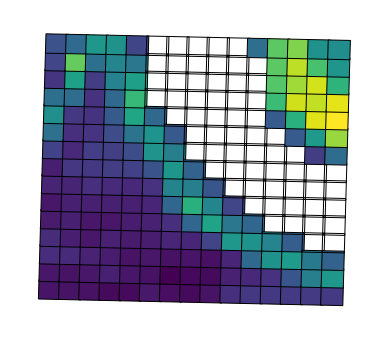

In [20]:
gplt.choropleth(samplePolyDf, hue='elevation')

In [21]:
del samplePolyDf
del lasDf
del lasData
gc.collect()

9707

In [22]:
%%time
reducedDatas = []
for xmlFile in xmlFilesGeo.iterrows():
    
    filename = xmlFile[1]['ftpFileName'].split('/')[-1]
    try:
        (lasData, pointType) = loadLas((filename, filename.replace('.zip','.las')))
    except LoadFileException:
        continue
        
    curBounds = [ lasData['x'].min(), lasData['y'].min(), lasData['x'].max(), lasData['y'].max() ]
    reducedDatas.append(makeSamplePolygons( curBounds, lasData, pointType))
    
        
    print('.', end='')
    
    
    

/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


....................................................................................................................................................................................................................................................................................................CPU times: user 16min 19s, sys: 27.3 s, total: 16min 46s
Wall time: 17min 16s


In [23]:
processedData = pd.concat(reducedDatas)
processedData.to_pickle('processedData.pickle')

In [24]:
processedData.count()

elevation    49899
geometry     57321
pointType    57321
dtype: int64

In [25]:
processedData.head()

,elevation,geometry,pointType
0,-0.668772,"POLYGON ((-89.89434 30.03741, -89.89320 30.037...",2
1,-1.159871,"POLYGON ((-89.89431 30.03831, -89.89317 30.038...",2
2,-0.255083,"POLYGON ((-89.89428 30.03921, -89.89314 30.039...",2
3,0.260106,"POLYGON ((-89.89425 30.04011, -89.89312 30.040...",2
4,0.217823,"POLYGON ((-89.89423 30.04101, -89.89309 30.040...",2


In [26]:
processedData.describe()

,elevation,pointType
count,49899.000000,57321.000000
mean,-0.010765,2.030163
std,1.395475,0.458517
min,-6.425172,2.000000
25%,-0.940757,2.000000
50%,0.084390,2.000000
75%,0.485017,2.000000
max,16.921864,9.000000


<AxesSubplot:>

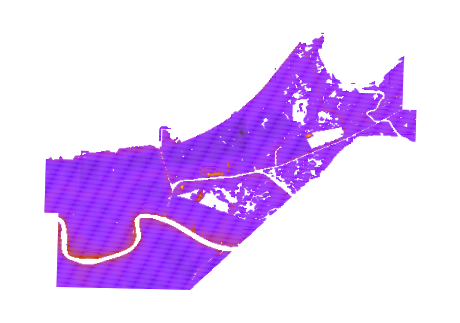

In [27]:
gplt.choropleth(processedData, hue='elevation', edgecolor=(1,0,0,0), cmap='gnuplot')

In [28]:
processedData.head()

,elevation,geometry,pointType
0,-0.668772,"POLYGON ((-89.89434 30.03741, -89.89320 30.037...",2
1,-1.159871,"POLYGON ((-89.89431 30.03831, -89.89317 30.038...",2
2,-0.255083,"POLYGON ((-89.89428 30.03921, -89.89314 30.039...",2
3,0.260106,"POLYGON ((-89.89425 30.04011, -89.89312 30.040...",2
4,0.217823,"POLYGON ((-89.89423 30.04101, -89.89309 30.040...",2
